# Project 1 AirBnB listings analysis
by Sandra Muschkorgel, Berlin 19th January 2021

## Introduction
In this report I will analyse AirBnB listings (incl. prices and reviews). The original data was provided by AirBnB via Udacity and comes in form of three csv files: calendar.csv, listings.csv and reviews.csv. All listings are located in Seattle (Washington, US). 

I performed the analysis in accordance with the CRISP-DM process:
* <a href="#business">Business Understanding</a>
* <a href="#data">Data Understanding</a>
* <a href="#prep">Data Preparation</a>
* <a href="#model">Modeling</a>
* <a href="#deploy">Evaluation and Deployment</a>

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score

import math
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
# Load csv files into separate dataframes
calendar = pd.read_csv('data/Seattle/calendar.csv')
listings = pd.read_csv('data/Seattle/listings.csv')
reviews = pd.read_csv('data/Seattle/reviews.csv')

***
<a id="business"></a>
## Business Understanding
AirBnB is often considered an alternative to hotels, lodgings, or any other traveller's accomodation. Though this is true, AirBnB listings greatly differ due to their individuality. Each listing has a different host, location, service, amenities and the like - making each of them a unique experience. This is why I want to focus on the questions below for my analysis:
1. Do prices display a strong relationship to location?
2. Do high performing hosts charge more?
3. What's the relationship between reviews and price?
4. Which features influence the price charged per night?
5. Which features influence the rate of positive reviews?

To answer these questions I will first take a look at the three files provided, understand the variables present and assess the data quality. I will then clean the data based on the findings from the previous step. Finally, I am able to create a model, evaluate its results and deploy them via a blog post. Some of the questions do not require a model, but can be answered with descriptive statistics instead.

***
<a id="data"></a>
## Data Understanding
### `calendar`

In [3]:
calendar.shape

(1393570, 4)

In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
calendar.tail()

,listing_id,date,available,price
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN
1393569,10208623,2017-01-02,f,NaN


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [7]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [8]:
# Proportion of booked listings to overall capacity
calendar.price.isnull().sum() / calendar.shape[0]

0.32938998399793334

In [9]:
calendar.duplicated().sum()

0

The **calendar dataset** covers one year worth of bookings for AirBnB listings in Seattle from Jan, 4 2016 until Jan, 2 2017. The four columns represent:
* the *listing_id*
* the booking *date*
* the availability *available* (t - available, f - unavailable)
* the *price* per night if the listing is available (in USD)

33% of nights were booked during that timeframe. There are no duplicated entries.

### `listings`

In [10]:
listings.shape, listings.id.nunique(), listings.duplicated().sum()

((3818, 92), 3818, 0)

In [11]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [12]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [13]:
listings.space.sample(10)

1446                                                  NaN
555     My condo is located in the center of Seattle. ...
241     Late 60's quirky, clean and comfortable 2bd Pe...
3064    Our suite is perfect for up to four people. On...
1562                                                  NaN
56      The view from our apartment makes it particula...
2359    Charming main floor bedroom with two twin beds...
1241    Posh, brand new open floor plan in a gorgeous ...
3221                About 600 sq. ft. studio with carpet.
804                                                   NaN
Name: space, dtype: object

In [14]:
listings.experiences_offered.value_counts()

none    3818
Name: experiences_offered, dtype: int64

In [15]:
listings.host_has_profile_pic.value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

In [16]:
listings.city.value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
seattle                     1
西雅图                         1
Ballard, Seattle            1
Phinney Ridge Seattle       1
Name: city, dtype: int64

In [17]:
listings.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [18]:
listings.market.value_counts()

Seattle    3818
Name: market, dtype: int64

In [19]:
listings.smart_location.value_counts()

Seattle, WA                  3810
Seattle , WA                    2
West Seattle, WA                2
Ballard, Seattle, WA            1
西雅图, WA                         1
seattle, wa                     1
Phinney Ridge Seattle, WA       1
Name: smart_location, dtype: int64

In [20]:
listings.maximum_nights.value_counts()

1125    2453
30       183
365      148
14       123
7        108
        ... 
500        1
234        1
260        1
330        1
1825       1
Name: maximum_nights, Length: 68, dtype: int64

In [21]:
listings.has_availability.value_counts()

t    3818
Name: has_availability, dtype: int64

The **listings dataset** contains 3,818 unique listings with 92 columns. Before continuing with my assessment I will reduce this dataset significantly, i.e. dropping columns I will not consider for my analysis. The reasons for dropping these columns can be summarized as follows:
* columns with only one value in it (ex. *experiences_offered*) or one value with several representations (ex. *city*)
* sensitive data (ex. *host_name* or *host_location*)
* url-related columns (ex. *thumbnail_url*)
* columns which can be expressed via another column in order to avoid multicollinearity (ex. *bathrooms* and *bedrooms*)
* highly skewed columns (ex. *host_has_profile_pic*)

In [22]:
listings_short = listings.copy()
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'space', 'experiences_offered', 
             'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 
             'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
             'host_verifications', 'host_has_profile_pic', 'street', 'neighbourhood', 'neighbourhood_cleansed', 
             'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 
             'longitude', 'is_location_exact', 'bathrooms', 'beds', 'bed_type', 'square_feet', 
             'guests_included', 'extra_people', 'maximum_nights', 'calendar_updated', 'has_availability', 
             'availability_30', 'availability_60', 'availability_90', 'availability_365', 
             'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 
             'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count']
listings_short.drop(drop_cols, axis=1, inplace=True)

In [23]:
listings_short.head()

,id,summary,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
0,241032,NaN,Make your self at home in this charming one-be...,956883,2011-08-11,within a few hours,96%,100%,f,t,...,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,4.07
1,953595,Chemically sensitive? We've removed the irrita...,Chemically sensitive? We've removed the irrita...,5177328,2013-02-21,within an hour,98%,100%,t,t,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,1.48
2,3308979,New modern house built in 2013. Spectacular s...,New modern house built in 2013. Spectacular s...,16708587,2014-06-12,within a few hours,67%,100%,f,t,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,1.15
3,7421966,A charming apartment that sits atop Queen Anne...,A charming apartment that sits atop Queen Anne...,9851441,2013-11-06,NaN,NaN,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
4,278830,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,1452570,2011-11-29,within an hour,100%,NaN,f,t,...,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,0.89


In [24]:
listings_short.describe()

,id,host_id,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,3.818000e+03,3.818000e+03,3818.000000,3812.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3191.000000
mean,5.550111e+06,1.578556e+07,3.349398,1.307712,2.369303,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.078919
std,2.962660e+06,1.458382e+07,1.977599,0.883395,16.305902,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,1.822348
min,3.335000e+03,4.193000e+03,1.000000,0.000000,1.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.020000
25%,3.258256e+06,3.275204e+06,2.000000,1.000000,1.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.695000
50%,6.118244e+06,1.055814e+07,3.000000,1.000000,2.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000
75%,8.035127e+06,2.590309e+07,4.000000,2.000000,2.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000
max,1.034016e+07,5.320861e+07,16.000000,7.000000,1000.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000


In [25]:
listings_short[listings_short.bedrooms == 0].property_type.value_counts()

Apartment      277
House           53
Loft            13
Bungalow         8
Other            5
Cabin            4
Condominium      4
Camper/RV        4
Townhouse        2
Treehouse        1
Yurt             1
Name: property_type, dtype: int64

In [26]:
listings_short.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [27]:
listings_short[listings_short.minimum_nights == 1000].description.item()

"This beautiful contemporary 1 bedroom apartment is located in the heart of Capitol Hill, Seattle's best neighborhood for restaurants, nightlife, and boutique shopping. Literally less than a block away from Cafes, Restaurants, Groceries Bars and more!"

In [28]:
listings_short.minimum_nights.value_counts().sort_values(ascending=False)

1       1610
2       1423
3        480
4        122
5         67
7         50
6         16
14        16
20        11
30         6
10         5
13         2
21         1
1000       1
29         1
28         1
26         1
11         1
12         1
8          1
15         1
31         1
Name: minimum_nights, dtype: int64

In [29]:
listings_short[listings_short.number_of_reviews == 474]

,id,summary,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
1447,208356,** Please read our entire listing description ...,** Please read our entire listing description ...,1025723,2011-08-27,within an hour,100%,100%,f,t,...,95.0,10.0,10.0,10.0,10.0,9.0,9.0,f,strict,8.98


In [30]:
listings_short.isnull().sum()

id                                 0
summary                          177
description                        0
host_id                            0
host_since                         2
host_response_time               523
host_response_rate               523
host_acceptance_rate             773
host_is_superhost                  2
host_identity_verified             2
neighbourhood_group_cleansed       0
property_type                      1
room_type                          0
accommodates                       0
bedrooms                           6
amenities                          0
price                              0
weekly_price                    1809
monthly_price                   2301
security_deposit                1952
cleaning_fee                    1030
minimum_nights                     0
number_of_reviews                  0
first_review                     627
last_review                      627
review_scores_rating             647
review_scores_accuracy           658
r

In [31]:
# Randomly chosen example to compare the summary and description column
index = listings_short[listings_short.summary.notnull()].sample(1).index
print(listings_short.loc[index, 'summary'].item())
print('\n')
print(listings_short.loc[index, 'description'].item())

READ!*females only*I DO NOT HAVE WIFI* A great option for travelers on a BUDGET! A clean, cozy and quiet little spot, conveniently located downtown near many tourist attractions. The beds are in the living room but there is a curtain for privacy.


READ!*females only*I DO NOT HAVE WIFI* A great option for travelers on a BUDGET! A clean, cozy and quiet little spot, conveniently located downtown near many tourist attractions. The beds are in the living room but there is a curtain for privacy. My apartment is VERY SMALL and I would NOT feel comfortable sharing it with men I don't know. Women and children ONLY, please.  This apartment is located in a historic building. It was built in 1891 as a hotel for miners. The building is very OLD, interesting and unique. The  apartment is located on the fourth floor and there is NO ELEVATOR.  Also, the BATHROOM is in the HALL like an old-fashioned guest house. Three other tenants on my floor use it also. I CLEAN it frequently. You are welcome to use

In [32]:
# Listings without reviews
unreviewed_listings = listings_short[listings_short.reviews_per_month.isnull()]
unreviewed_listings

,id,summary,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
3,7421966,A charming apartment that sits atop Queen Anne...,A charming apartment that sits atop Queen Anne...,9851441,2013-11-06,NaN,NaN,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
18,7735464,The second room in our spacious 2BR / 2 Bath a...,The second room in our spacious 2BR / 2 Bath a...,6170760,2013-04-30,NaN,NaN,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
23,10106055,"Greetings! Our home is a beautiful, 1920's 4 ...","Greetings! Our home is a beautiful, 1920's 4 ...",51860756,2015-12-20,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
26,9025039,Our cozy little bungalow is the perfect place ...,Our cozy little bungalow is the perfect place ...,68155,2010-01-06,within a few hours,100%,100%,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
46,9550869,Beautiful craftsman in the center of Queen Ann...,Beautiful craftsman in the center of Queen Ann...,12867960,2014-03-06,within a day,90%,100%,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,5482204,Seattle's most elegant and romantic lit...,Seattle's most elegant and romantic lit...,28432113,2015-02-27,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,NaN
3802,8562314,"Our rare for its location, 2 bedroom and 1 bat...","Our rare for its location, 2 bedroom and 1 bat...",18774473,2014-07-23,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
3815,10267360,"Very comfortable lower unit. Quiet, charming m...","Very comfortable lower unit. Quiet, charming m...",52791370,2015-12-30,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,NaN
3816,9604740,Cozy studio condo in the heart on Madison Park...,Cozy studio condo in the heart on Madison Park...,25522052,2015-01-03,within an hour,100%,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,NaN


In [33]:
unreviewed_listings.host_acceptance_rate.isnull().sum()

287

In [34]:
# Listings should not appear in reviews dataframe
reviews[reviews.listing_id.isin(unreviewed_listings.id.to_list())]

,listing_id,id,date,reviewer_id,reviewer_name,comments


In [35]:
listings_short[listings_short.bedrooms.isnull()].property_type

1429    Apartment
1492    Apartment
1493        Other
1853    Apartment
2619        House
2915    Apartment
Name: property_type, dtype: object

In [36]:
listings_short[listings_short.property_type.isnull()].description.item()

'Welcome! If you stay here you will be living in a light filled two bedroom upper and ground level apartment (in a two apartment home). During your stay you will be welcome to share in our fresh eggs from the chickens and garden produce in season! Welcome!  Come enjoy your time in Seattle at a lovely urban farmstead.  There are two bedrooms each with a queen bed, full bath, living room and kitchen with wood floors throughout.  During your stay you will be welcome to eat fresh eggs from the chickens and possibly fruit/veggies from the garden if you are in luck!   We are family friendly and have a down to earth atmosphere.  There is a large covered back porch and grill for hanging out especially in summer and a treehouse for up in the trees hammock time! Walking distance to Othello Light Rail Station for easy access to downtown.  Also nearby is the fantastic Seward Park and the Kubota Gardens for outdoorsy loveliness.  New last year is out beautiful Rainier Beach indoor swimming pool com

In [37]:
# Listings without host performance data
listings_short[listings_short.host_acceptance_rate.isnull()]

,id,summary,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
3,7421966,A charming apartment that sits atop Queen Anne...,A charming apartment that sits atop Queen Anne...,9851441,2013-11-06,NaN,NaN,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
4,278830,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,1452570,2011-11-29,within an hour,100%,NaN,f,t,...,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,0.89
5,5956968,We're renting out a small private unit of one ...,We're renting out a small private unit of one ...,326758,2010-12-25,NaN,NaN,NaN,f,t,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,2.45
18,7735464,The second room in our spacious 2BR / 2 Bath a...,The second room in our spacious 2BR / 2 Bath a...,6170760,2013-04-30,NaN,NaN,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
19,6291829,This home built in 1909. It has 5 bedrooms a...,This home built in 1909. It has 5 bedrooms a...,32713558,2015-05-05,NaN,NaN,NaN,f,t,...,85.0,10.0,9.0,9.0,9.0,8.0,8.0,f,flexible,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,5482204,Seattle's most elegant and romantic lit...,Seattle's most elegant and romantic lit...,28432113,2015-02-27,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,NaN
3802,8562314,"Our rare for its location, 2 bedroom and 1 bat...","Our rare for its location, 2 bedroom and 1 bat...",18774473,2014-07-23,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
3815,10267360,"Very comfortable lower unit. Quiet, charming m...","Very comfortable lower unit. Quiet, charming m...",52791370,2015-12-30,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,NaN
3816,9604740,Cozy studio condo in the heart on Madison Park...,Cozy studio condo in the heart on Madison Park...,25522052,2015-01-03,within an hour,100%,NaN,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,NaN


In [38]:
for _ in range(10):
    print(listings_short.sample(1).amenities.values)

['{TV,"Cable TV",Internet,"Wireless Internet","Free Parking on Premises",Heating,Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo}']
['{Internet,"Wireless Internet",Kitchen,Heating,Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo,"Lock on Bedroom Door","24-Hour Check-in",Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}']
['{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo}']
['{TV,Internet,"Wireless Internet","Pets live on this property",Dog(s),Heating,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo}']
['{Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed",Breakfast,"Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","

In [39]:
listings_short[listings_short.amenities == '{}']

,id,summary,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
70,7021702,"Modern and cozy condo in the heart of Ballard,...","Modern and cozy condo in the heart of Ballard,...",36805437,2015-06-26,NaN,NaN,NaN,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
117,6337492,"Nice, clean and quite 1 bedroom apartment. Wak...","Nice, clean and quite 1 bedroom apartment. Wak...",32998581,2015-05-09,within an hour,100%,100%,f,t,...,92.0,9.0,8.0,9.0,10.0,10.0,10.0,f,flexible,0.65
229,10229434,Perfect location for getting anywhere in Seatt...,Perfect location for getting anywhere in Seatt...,21616710,2014-09-21,within an hour,100%,100%,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
264,9679300,This 1BR apt comfortably sleeps 2 and is centr...,This 1BR apt comfortably sleeps 2 and is centr...,49371015,2015-11-18,within a few hours,83%,100%,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
316,10265391,"This quiet, artist apartment has lots of windo...","This quiet, artist apartment has lots of windo...",10607280,2013-12-13,within an hour,100%,100%,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
487,5648564,Queen Anne condo w/ views of Fremont and Balla...,Queen Anne condo w/ views of Fremont and Balla...,24091986,2014-11-24,within a day,50%,100%,f,t,...,100.0,10.0,10.0,9.0,9.0,10.0,10.0,f,strict,0.41
568,5364609,"Very spacious! 717 sq ft, with wifi, balcony o...","Very spacious! 717 sq ft, with wifi, balcony o...",15171111,2014-05-06,a few days or more,33%,100%,f,t,...,97.0,10.0,8.0,10.0,9.0,9.0,10.0,f,flexible,0.57
637,8968925,Great living space close to downtown. Walking ...,Great living space close to downtown. Walking ...,8540901,2013-08-30,a few days or more,40%,100%,f,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
835,9711153,Enjoy a quiet corner abode just blocks from so...,Enjoy a quiet corner abode just blocks from so...,43229398,2015-09-03,within a few hours,100%,100%,f,f,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,flexible,5.62
859,9448215,"Large room in Seattle's best neighborhood, ca...","Large room in Seattle's best neighborhood, ca...",48441443,2015-11-07,within a day,60%,100%,f,t,...,100.0,10.0,8.0,10.0,10.0,10.0,10.0,f,flexible,1.00


The **listings_short dataset** contains many missing values that need to be dealt with during the next step. 

Missing values for the price-related columns can easily be explained. Weekly or monthly prices usually are lower than applying the daily rate for the entire stay. It's an incentive to stay longer, avoiding the hassle of constant check-in and check-out for the host. Under the assumption that listings with missing values in these columns, just do not have a lowered rate, I will impute the NaNs by calculating a weekly and monthly price based on the daily rate. I will aproach the cleaning fee and security deposit similarly. Assuming there is no fee or deposit, if values are missing, I can replace the NaNs with 0. For missing data in the bedrooms column I will impute 1, assuming that there is at least 1 bedroom for an AirBnB listing. The description of the one row with a missing property type labels this as an apartment. Since the summary column is a subset of the description column, I will drop the entire column. 

Missing values for reviews and host performance data on the other hand cannot be dealt with in the same fashion: 
* Out of 627 listings without any review data 287 also do not have any host performance data (like *host_acceptance_rate*). So there is some overlap, but not entirely.
* Both, review and host performance columns, are central to answering some of my questions, I will have to drop these rows in order to create a model.
* I also decided to drop the entire column *host_acceptance_rate* since it has the most missing values among the host performance columns and is not purely based on the host performance.

The *amenities* column features 45 rows without any entries. These are technically no missing values, just empty dictionaries. I won't change or drop any rows here. During the modelling step I will extract specific aminities.

### `reviews`

In [40]:
reviews.shape

(84849, 6)

In [41]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [42]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [43]:
# Proportion of unique listings with a review
reviews.listing_id.nunique() / listings.shape[0]

0.8357778941854374

In [44]:
# Proportion of unique reviewers
reviews.reviewer_id.nunique() / reviews.shape[0]

0.8925267239448903

In [45]:
# Are there high frequency reviewers?
reviews_sub = reviews.reviewer_id.value_counts()
reviews_sub.nlargest(10)

206203      67
15121499    32
5775807     19
2734499     19
29590276    18
7448809     17
8013961     16
1971733     14
41158892    14
5053141     14
Name: reviewer_id, dtype: int64

In [46]:
reviews[reviews.reviewer_id == reviews_sub.index[0]].listing_id.value_counts().nlargest(10)

706385     11
63308       7
741699      7
774659      5
491958      3
20927       3
2621746     2
4777832     2
215882      2
1204142     1
Name: listing_id, dtype: int64

In [47]:
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [48]:
reviews[reviews.comments.isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


In [49]:
(reviews.duplicated()).sum()

0

The **reviews dataset** contains 84,849 reviews of which 89% are made by unique reviewers. 84% of all listings have a review attached to them. 18 reviews do not contain a comment. There are no duplicated entries. 

The six columns can be grouped as follows:
* id's: *listing_id*, *reviewer_id* and review *id*
* the *reviewer_name* and the *date* of posting the review
* the actual review or *comments*

### Assessment summary

**`calendar`**
* erronuous datatypes: 
  * *date* object &rarr; datetime
  * *available* object &rarr; boolean
  * *price* object &rarr; float
* dollar sign in *price* column
  
**`listings_short`**
* inaccurate entry of 1,000 in *minimum_nights* column 
* *summary* column is a subset of *description* column
* no consistency in *bedrooms* column: some hosts indicate an apartment as zero bedrooms others define it as having one bedroom
* missing values in the following columns: *summary*, *host_since*, *host_response_time*, *host_response_rate*, *host_acceptance_rate*, *host_is_superhost*, *host_identity_verified*, *property_type*, *bedrooms*, *weekly_price*, *monthly_price*, *security_deposit*, *cleaning_fee*, *first_review*, *last_review*, *review_scores_rating*, *review_scores_accuracy*, *review_scores_cleanliness*, *review_scores_checkin*, *review_scores_communication*, *review_scores_location*, *review_scores_value*, *reviews_per_month*
* erronuous datatypes:
  * *host_since*, *first_review*, *last_review* object &rarr; datetime
  * *host_is_superhost*, *host_identity_verified*, *instant_bookable* object &rarr; boolean
  * *bedrooms* float &rarr; integer
  * *host_response_rate*, *price*, *weekly_price*, *monthly_price*, *cleaning_fee*, *security_deposit* object &rarr; float

**`reviews`**
* reviewer_name sensitive information
* 18 reviews without an actual comment
* erronuous datatype: *date* object &rarr; datetime

***
<a id="prep"></a>
## Data Preparation

In [50]:
calendar_cleaned = calendar.copy()
listings_cleaned = listings_short.copy()
reviews_cleaned = reviews.copy()

In [51]:
def remove_currency_signs(df, col):
    """Remove dollar sign and thousand separator."""
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(',', '')

In [52]:
def convert_to_bool(df, col):
    """Convert object columns to boolean."""
    df[col] = df[col].replace({'f': 0, 't': 1})
    df[col] = df[col].astype(bool)

### `calendar_cleaned`

##### Convert datatypes

In [53]:
calendar_cleaned['date'] = pd.to_datetime(calendar_cleaned['date'])

convert_to_bool(calendar_cleaned, 'available')

calendar_cleaned['price'].fillna('0', inplace=True)
remove_currency_signs(calendar_cleaned, 'price')
calendar_cleaned['price'] = calendar_cleaned['price'].astype(float)

In [54]:
calendar_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  bool          
 3   price       1393570 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 33.2 MB


### `listings_cleaned`

##### Correct inaccurate entry of 1,000 minimum nights

In [55]:
row = listings_cleaned[listings_cleaned.minimum_nights == 1000].index
listings_cleaned.loc[row, 'minimum_nights'] = 1

In [56]:
listings_cleaned.minimum_nights.describe()

count    3818.000000
mean        2.107648
std         2.251350
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        31.000000
Name: minimum_nights, dtype: float64

##### Drop summary and host_acceptance_rate columns

In [57]:
listings_cleaned.drop(['summary', 'host_acceptance_rate'], axis=1, inplace=True)

In [58]:
assert 'summary' not in listings_cleaned.columns
assert 'host_acceptance_rate' not in listings_cleaned.columns

##### Fill in missing values for price columns and convert their datatype to float

In [59]:
for col in ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'security_deposit']:
    remove_currency_signs(listings_cleaned, col)
    listings_cleaned[col] = listings_cleaned[col].astype(float)

In [60]:
row = listings_cleaned[listings_cleaned.weekly_price.isnull()].index
listings_cleaned.loc[row, 'weekly_price'] = 7 * listings_cleaned.loc[row, 'price']

In [61]:
row = listings_cleaned[listings_cleaned.monthly_price.isnull()].index
listings_cleaned.loc[row, 'monthly_price'] = (365 / 12) * listings_cleaned.loc[row, 'price']

In [62]:
listings_cleaned['security_deposit'].fillna(0, inplace=True)
listings_cleaned['cleaning_fee'].fillna(0, inplace=True)

##### Fill in missing values for bedroom column and change zero bedrooms to one bedroom

In [63]:
listings_cleaned['bedrooms'].fillna(1, inplace=True)
listings_cleaned['bedrooms'] = listings_cleaned['bedrooms'].astype(int)

In [64]:
listings_cleaned.loc[listings_cleaned[listings_cleaned.bedrooms == 0].index, 'bedrooms'] = 1

In [65]:
assert listings_cleaned[listings_cleaned.bedrooms == 0].empty

##### Convert remaining columns to their appropriate datatype

In [66]:
for col in ['host_since', 'first_review', 'last_review']:
    listings_cleaned[col] = pd.to_datetime(listings_cleaned[col])
    
for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
    convert_to_bool(listings_cleaned, col)

##### Impute 'Apartment' for listing with missing property type

In [67]:
listings_cleaned.loc[listings_cleaned[listings_cleaned.property_type.isnull()].index, 'property_type'] = 'Apartment'

##### Drop rows with missing reviews and host performance data

In [68]:
listings_cleaned.drop(listings_cleaned[listings_cleaned.review_scores_accuracy.isnull()].index, inplace=True)

In [69]:
listings_cleaned.drop(listings_cleaned[listings_cleaned.host_response_time.isnull()].index, inplace=True)

In [70]:
listings_cleaned.isnull().sum()

id                              0
description                     0
host_id                         0
host_since                      0
host_response_time              0
host_response_rate              0
host_is_superhost               0
host_identity_verified          0
neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bedrooms                        0
amenities                       0
price                           0
weekly_price                    0
monthly_price                   0
security_deposit                0
cleaning_fee                    0
minimum_nights                  0
number_of_reviews               0
first_review                    0
last_review                     0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_

##### Convert host_response_rate to float

In [71]:
listings_cleaned.host_response_rate = listings_cleaned.host_response_rate.str.replace('%', '').astype(float)

In [72]:
listings_cleaned.shape

(2852, 33)

In [73]:
listings_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2852 entries, 0 to 3814
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            2852 non-null   int64         
 1   description                   2852 non-null   object        
 2   host_id                       2852 non-null   int64         
 3   host_since                    2852 non-null   datetime64[ns]
 4   host_response_time            2852 non-null   object        
 5   host_response_rate            2852 non-null   float64       
 6   host_is_superhost             2852 non-null   bool          
 7   host_identity_verified        2852 non-null   bool          
 8   neighbourhood_group_cleansed  2852 non-null   object        
 9   property_type                 2852 non-null   object        
 10  room_type                     2852 non-null   object        
 11  accommodates                  

### `reviews_cleaned`

##### Drop reviewer_name column

In [74]:
reviews_cleaned.drop('reviewer_name', axis=1, inplace=True)

##### Drop rows with missing comments

In [75]:
reviews_cleaned.dropna(subset=['comments'], axis=0, inplace=True, how='any')

In [76]:
reviews_cleaned.isnull().sum()

listing_id     0
id             0
date           0
reviewer_id    0
comments       0
dtype: int64

##### Convert date column to datetime

In [77]:
reviews_cleaned.date = pd.to_datetime(reviews_cleaned.date)

In [78]:
reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84831 entries, 0 to 84848
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   listing_id   84831 non-null  int64         
 1   id           84831 non-null  int64         
 2   date         84831 non-null  datetime64[ns]
 3   reviewer_id  84831 non-null  int64         
 4   comments     84831 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.9+ MB


In [125]:
calendar_cleaned.to_csv('data/Seattle/cleaned_calendar.csv', index=False)
listings_cleaned.to_csv('data/Seattle/cleaned_listings.csv', index=False)
reviews_cleaned.to_csv('data/Seattle/cleaned_reviews.csv', index=False)

***
<a id="model"></a>
## *Descriptive Statistics*
Before moving on to the actual modeling part of this analysis, I will use descriptive statistics to answer some of my questions and explore the dataset further.
1. How do prices differ between different neighbourhoods?
2. Do high performing hosts charge more?
3. What's the relationship between reviews and price?

In [126]:
# How busy is the Seattle AirBnB market?
# Load in calendar and listings dataset 
df_calendar = pd.read_csv('data/Seattle/cleaned_calendar.csv')
df_listings = pd.read_csv('data/Seattle/cleaned_listings.csv')

In [127]:
price_heights = df_calendar.groupby(pd.DatetimeIndex(df_calendar.date).month).price.mean()
availability_heights = df_calendar.groupby(pd.DatetimeIndex(df_calendar.date).month).available.mean()

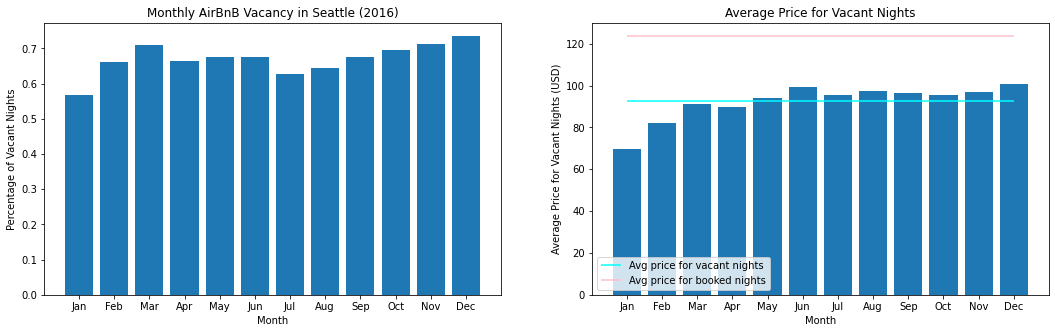

In [128]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.bar(availability_heights.index, availability_heights)
plt.title('Monthly AirBnB Vacancy in Seattle (2016)')
plt.xlabel('Month')
plt.ylabel('Percentage of Vacant Nights')
ticks = np.arange(1, 13)
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks, labels)

plt.subplot(1, 2, 2)
plt.bar(price_heights.index, price_heights)
plt.hlines(df_calendar.price.mean(), xmin=1, xmax=12, color='cyan')
plt.hlines(df_listings.price.mean(), xmin=1, xmax=12, color='pink')
plt.title('Average Price for Vacant Nights')
plt.xlabel('Month')
plt.ylabel('Average Price for Vacant Nights (USD)')
plt.xticks(ticks, labels)
plt.legend(labels=['Avg price for vacant nights', 'Avg price for booked nights'], loc=3);

**Results:** 

* Jan highest booking rates
* Dec lowest booking rates
However, whether these vacancies can be considered high or low cannot be assessed with this stand-alone dataset. A city-to-city or year-to-year comparison could yield deeper insights. 

Interestingly though the distribution of vacant listings looks similar to the average price per vacant listing. The remaining 55% of available nights were offered at the lowest average price compared to the remaining year. It seems that the vacant listings were put out at a lower rate.

I added a pink horizontal line to represent the overall average price for booked nights. It lies far above the average price for vacant nights. Highlighting once more the previously stated finding.

Let's look at some actual bookings. 

In [129]:
price_locations = df_listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False)

In [130]:
location_cheap = price_locations.index[len(price_locations)-1]
location_expensive = price_locations.index[0]

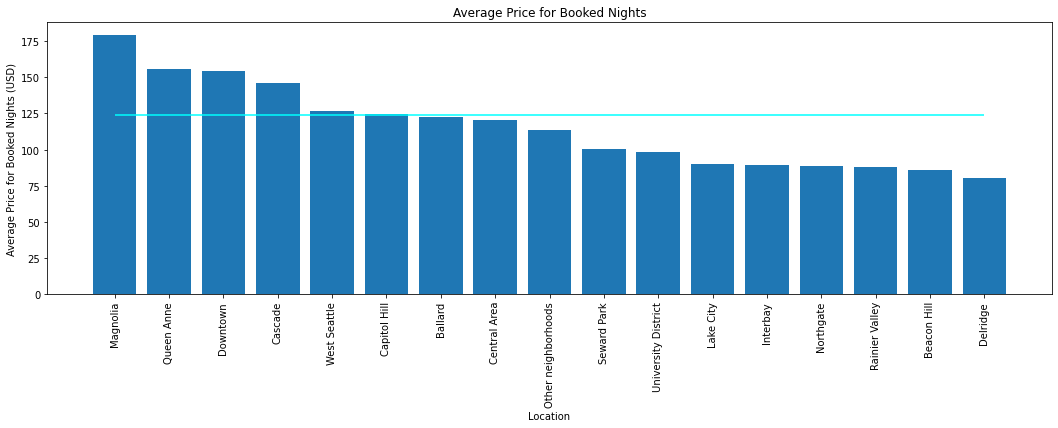

In [131]:
plt.figure(figsize=(18,5))
plt.bar(price_locations.index, price_locations)
plt.hlines(df_listings.price.mean(), xmin=location_expensive, xmax=location_cheap, color='cyan')
plt.xticks(rotation=90)
plt.title('Average Price for Booked Nights')
plt.xlabel('Location')
plt.ylabel('Average Price for Booked Nights (USD)');

In [132]:
df_listings[df_listings.neighbourhood_group_cleansed.isin([location_expensive, location_cheap])].groupby('neighbourhood_group_cleansed')['price'].mean()

neighbourhood_group_cleansed
Delridge     80.120690
Magnolia    179.181818
Name: price, dtype: float64

**Results:**
There is a USD100-difference of average pricing between the most expensive location *Magnolia* and the lowest priced area *Delridge*.

In [133]:
def price_diff(price_col, score_col, cat_col):
    """
    Compares prices based on a host's review score, separated by a categorical column.
    
    ARGUMENTS:
    price_col - price variable that will be compared
    score_col - scoring metric
    cat_col - categorical variable to group the dataframe
    
    RETURN VALUE:
    df - dataframe
    """
    
    # Dataset split exactly in half, alternatives: 75th percentile or the mean
    threshold = df_listings[score_col].quantile(0.5)
    # High performers belong to the better 50%
    upper_df = df_listings[df_listings[score_col] >= threshold].groupby(cat_col)[price_col].mean().sort_values(ascending=False).to_frame().reset_index()
    upper_df = upper_df.rename(columns={price_col:'{}_high_performers'.format(price_col)})
    # Low performers belong to the lower 50%
    lower_df = df_listings[df_listings[score_col] < threshold].groupby(cat_col)[price_col].mean().sort_values(ascending=False).to_frame().reset_index()
    lower_df = lower_df.rename(columns={price_col:'{}_low_performers'.format(price_col)})
    
    df = upper_df.merge(lower_df, on=cat_col)
    df['diff'] = df[df.columns[1]] - df[df.columns[2]]
    
    return df 
    

In [134]:
df_sub = price_diff('price', 'review_scores_location', 'neighbourhood_group_cleansed')
df_sub.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,neighbourhood_group_cleansed,price_high_performers,price_low_performers,diff
0,Magnolia,208.250000,128.312500,79.937500
1,Queen Anne,164.705521,124.893617,39.811904
2,Downtown,156.374640,147.047059,9.327581
3,Cascade,140.717949,158.125000,-17.407051
4,West Seattle,128.940171,115.296296,13.643875
5,Central Area,125.459119,114.829268,10.629851
6,Capitol Hill,123.147059,131.296875,-8.149816
7,Ballard,119.986014,132.694444,-12.708430
8,Other neighborhoods,115.720698,109.611702,6.108996
9,Seward Park,110.000000,94.869565,15.130435


In [135]:
df_sub = price_diff('price', 'review_scores_rating', 'host_response_time')
df_sub.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,host_response_time,price_high_performers,price_low_performers,diff
0,a few days or more,146.538462,122.375000,24.163462
1,within a day,140.695312,126.851163,13.844150
2,within a few hours,138.548694,129.684466,8.864228
3,within an hour,121.844068,104.184543,17.659525


In [136]:
df_sub = price_diff('price', 'review_scores_rating', 'property_type')
df_sub.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,property_type,price_high_performers,price_low_performers,diff
0,Boat,775.000000,95.000000,680.000000
1,Condominium,158.432432,135.214286,23.218147
2,Loft,140.937500,138.600000,2.337500
3,Chalet,135.000000,62.000000,73.000000
4,House,132.353675,116.310580,16.043095
5,Apartment,126.630216,117.822034,8.808182
6,Townhouse,123.192308,106.181818,17.010490
7,Other,114.500000,75.000000,39.500000
8,Bungalow,104.166667,86.333333,17.833333
9,Cabin,103.666667,103.600000,0.066667


In [137]:
df_sub = price_diff('price', 'review_scores_communication', 'cancellation_policy')
df_sub.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,cancellation_policy,price_high_performers,price_low_performers,diff
0,strict,152.325926,142.260274,10.065652
1,moderate,111.409502,99.984733,11.424769
2,flexible,97.936027,100.468354,-2.532327


**Results:** 
[...]

## Modeling

In [138]:
def get_dummies_df(df, cat_cols):
    """
    Creates dummy variables for categorical columns.
    
    ARGUMENTS:
    df - dataframe to be transformed
    cat_cols - categorical columns
    
    RETURN VALUE:
    df - transformed dataframe
    """

    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    
    return df


In [195]:
def linear_regression_model(df, target_col):
    """
    Creates a linear regression model fitted on a given training dataset.
    
    ARGUMENTS:
    df - dataframe containing all data
    target_col - target variable name
    
    RETURN VALUES:
    lm_model - trained regression model
    test_score - r2 score on the test data
    train_score - r2 score on the train data
    """
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    y_pred_test = lm_model.predict(X_test)
    y_pred_train = lm_model.predict(X_train)
    
    test_score = r2_score(y_test, y_pred_test)
    train_score = r2_score(y_train, y_pred_train)
    
    return X_train, lm_model, test_score, train_score

In [140]:
num_cols = df_listings.select_dtypes(include=np.number).columns

In [141]:
num_cols

Index(['id', 'host_id', 'host_response_rate', 'accommodates', 'bedrooms',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [142]:
bool_cols = df_listings.select_dtypes(include=bool).columns

In [143]:
bool_cols

Index(['host_is_superhost', 'host_identity_verified', 'instant_bookable'], dtype='object')

In [144]:
cat_cols = df_listings.select_dtypes(include=object).columns

In [145]:
cat_cols

Index(['description', 'host_since', 'host_response_time',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'amenities', 'first_review', 'last_review', 'cancellation_policy'],
      dtype='object')

### Model 1
For the first model, I will include all variables.

In [146]:
df_model1 = df_listings.drop(['id', 'host_id', 'description', 'amenities', 
                              'host_since', 'first_review', 'last_review'], axis=1)

In [147]:
df_model1 = get_dummies_df(df_model1, cat_cols)

In [148]:
df_model1.columns = [col.replace(' ', '_').lower() for col in df_model1.columns]
df_model1.columns = [col.replace('-', '').lower() for col in df_model1.columns]

In [149]:
df_model1.rename(columns={'property_type_bed_&_breakfast': 'property_type_bed_breakfast'}, inplace=True)
df_model1.rename(columns={'property_type_camper/rv': 'property_type_camper_rv'}, inplace=True)

In [150]:
lm_model1, test_score1, train_score1 = linear_regression_model(df_model1, 'price')

In [151]:
print(test_score1)
print(train_score1)

0.9444923651612314
0.9463597861687761


In [152]:
print(math.sqrt(test_score1))

0.9718499705001957


In [153]:
np.abs(lm_model1.coef_)

array([1.00821424e-01, 2.24502014e+00, 4.75903120e-01, 4.91035984e-01,
       4.44303095e+00, 1.07958294e-01, 6.42186182e-03, 8.02243105e-03,
       1.02047003e-02, 7.71519458e-01, 1.11302820e-02, 5.89406547e-02,
       8.65133296e-01, 5.38329773e-01, 5.28529589e-01, 2.93077089e-01,
       6.24137633e-01, 1.02185326e+00, 8.59463694e-01, 7.33681749e-01,
       6.38487940e+00, 6.44671974e+00, 7.58275731e+00, 5.56307247e+00,
       7.85173042e-02, 2.84930087e+00, 1.14671726e+00, 6.38578907e+00,
       2.29657406e+00, 1.12782063e+01, 2.15237081e-01, 8.75805352e+00,
       3.50074408e+00, 6.72535918e-01, 2.69619324e+00, 1.47127188e+00,
       3.04274788e+00, 3.62139243e+00, 1.69206719e+00, 1.54721858e+00,
       4.37035074e+00, 3.39803922e+00, 2.69977033e-01, 1.13749778e+00,
       1.04335633e+01, 5.84281269e+00, 7.01938703e-01, 5.33587204e-01,
       5.71639912e+00, 4.69682965e+00, 4.28016914e+00, 4.62522109e-01,
       0.00000000e+00, 4.57161631e+00, 1.74895376e+00, 4.53624493e+00,
      

In [154]:
features = "+".join(df_model1.columns)
y, X = dmatrices('price ~' + features, df_model1, return_type='dataframe')

In [155]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [156]:
vif

,VIF Factor,features
0,642.227506,Intercept
1,1.227264,host_is_superhost[T.True]
2,1.064244,host_identity_verified[T.True]
3,1.189611,instant_bookable[T.True]
4,1.915028,host_response_rate
5,3.958671,accommodates
6,4.223188,bedrooms
7,18.706592,price
8,24.030060,weekly_price
9,11.033846,monthly_price


### Model 2

In [157]:
df_model2 = df_listings.drop(['id', 'host_id', 'description', 'amenities', 'host_response_time', 'weekly_price',
                              'monthly_price', 'host_since', 'first_review', 'last_review'], axis=1)

In [158]:
df_model2 = get_dummies_df(df_model2, df_model2.select_dtypes(include=object).columns)

In [159]:
df_model2.columns = [col.replace(' ', '_').lower() for col in df_model2.columns]
df_model2.columns = [col.replace('-', '').lower() for col in df_model2.columns]

In [160]:
df_model2.rename(columns={'property_type_bed_&_breakfast': 'property_type_bed_breakfast'}, inplace=True)
df_model2.rename(columns={'property_type_camper/rv': 'property_type_camper_rv'}, inplace=True)

In [161]:
lm_model2, test_score2, train_score2 = linear_regression_model(df_model2, 'price')

In [162]:
print(test_score2)
print(train_score2)

0.6654977309560649
0.6104700965052439


In [163]:
print(math.sqrt(test_score2))

0.8157804428619657


In [164]:
np.abs(lm_model2.coef_)

array([1.57645146e-01, 1.26697174e+01, 3.87073612e+00, 7.16645753e+00,
       4.33573687e+01, 3.75654605e-02, 2.09959074e-01, 4.01470236e-01,
       1.17526110e-02, 5.99197531e-01, 3.19546431e+00, 1.61037464e+00,
       3.67390585e+00, 3.27183086e+00, 8.09519516e+00, 9.65825356e+00,
       1.26959725e+00, 4.24611436e+00, 8.37836811e+00, 1.80438785e+01,
       2.86654343e+01, 1.26801622e+00, 2.22595510e+01, 4.09167389e+01,
       2.64575374e+01, 1.02331027e+01, 2.84379766e+01, 1.50368156e+01,
       6.11381279e+00, 2.96286001e+01, 1.25833384e+01, 1.42613433e+01,
       8.11670852e+00, 1.67379765e-03, 2.04959227e+01, 2.68782269e+02,
       2.38325060e+00, 1.82003986e+01, 1.83680998e+01, 2.52285548e+01,
       9.06777561e+00, 6.58130754e+01, 5.99735496e+00, 1.96402263e+01,
       1.91694377e+01, 1.13838432e+01, 1.17550005e+01, 9.50978910e+00,
       1.73013511e+00, 1.90924728e+01, 4.84640285e+01, 1.84907056e+00,
       3.92886653e+00])

### Model 3

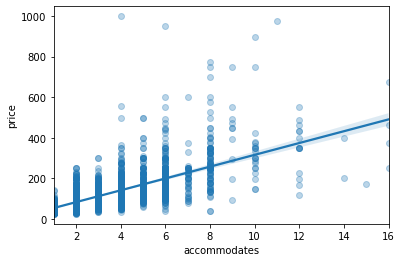

In [168]:
sb.regplot(data=df_listings, x='accommodates', y='price', scatter_kws={'alpha':0.3});

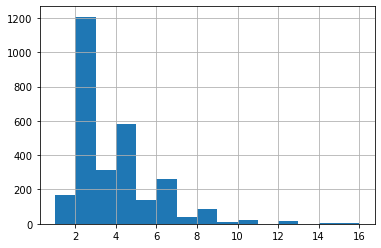

In [170]:
df_listings.accommodates.hist(bins=15);

In [171]:
df_model3 = df_listings[df_listings.accommodates == 2].drop(['id', 'host_id', 'description', 'amenities', 
                                                             'host_response_time', 'weekly_price', 'monthly_price', 
                                                             'host_since', 'first_review', 'last_review'], axis=1)

In [174]:
df_model3.bedrooms.value_counts()

1    1203
2       4
Name: bedrooms, dtype: int64

In [172]:
df_model3.drop('accommodates', axis=1, inplace=True)

In [175]:
df_model3.drop(df_model3[df_model3.bedrooms == 2].index, inplace=True)

In [176]:
df_model3.drop('bedrooms', axis=1, inplace=True)

In [178]:
df_model3 = get_dummies_df(df_model3, df_model3.select_dtypes(include=object).columns)

In [179]:
df_model3.columns = [col.replace(' ', '_').lower() for col in df_model3.columns]
df_model3.columns = [col.replace('-', '').lower() for col in df_model3.columns]

In [180]:
df_model3.rename(columns={'property_type_bed_&_breakfast': 'property_type_bed_breakfast'}, inplace=True)
df_model3.rename(columns={'property_type_camper/rv': 'property_type_camper_rv'}, inplace=True)

In [181]:
lm_model3, test_score3, train_score3 = linear_regression_model(df_model3, 'price')

In [182]:
print(test_score3)
print(train_score3)

0.45463427203488826
0.5036711666974623


In [183]:
print(math.sqrt(test_score3))

0.6742657280589666


In [164]:
np.abs(lm_model2.coef_)

array([1.57645146e-01, 1.26697174e+01, 3.87073612e+00, 7.16645753e+00,
       4.33573687e+01, 3.75654605e-02, 2.09959074e-01, 4.01470236e-01,
       1.17526110e-02, 5.99197531e-01, 3.19546431e+00, 1.61037464e+00,
       3.67390585e+00, 3.27183086e+00, 8.09519516e+00, 9.65825356e+00,
       1.26959725e+00, 4.24611436e+00, 8.37836811e+00, 1.80438785e+01,
       2.86654343e+01, 1.26801622e+00, 2.22595510e+01, 4.09167389e+01,
       2.64575374e+01, 1.02331027e+01, 2.84379766e+01, 1.50368156e+01,
       6.11381279e+00, 2.96286001e+01, 1.25833384e+01, 1.42613433e+01,
       8.11670852e+00, 1.67379765e-03, 2.04959227e+01, 2.68782269e+02,
       2.38325060e+00, 1.82003986e+01, 1.83680998e+01, 2.52285548e+01,
       9.06777561e+00, 6.58130754e+01, 5.99735496e+00, 1.96402263e+01,
       1.91694377e+01, 1.13838432e+01, 1.17550005e+01, 9.50978910e+00,
       1.73013511e+00, 1.90924728e+01, 4.84640285e+01, 1.84907056e+00,
       3.92886653e+00])

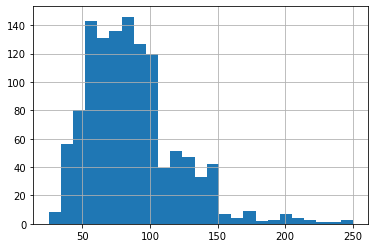

In [185]:
df_model3.price.hist(bins=25);

### Model 4

In [186]:
df_model4 = df_listings.drop(['id', 'host_id', 'description', 'amenities', 'host_response_time', 'weekly_price',
                              'monthly_price', 'host_since', 'first_review', 'last_review'], axis=1)

In [187]:
df_model4 = get_dummies_df(df_model4, df_model4.select_dtypes(include=object).columns)

In [188]:
df_model4.columns = [col.replace(' ', '_').lower() for col in df_model4.columns]
df_model4.columns = [col.replace('-', '').lower() for col in df_model4.columns]

In [189]:
df_model4.rename(columns={'property_type_bed_&_breakfast': 'property_type_bed_breakfast'}, inplace=True)
df_model4.rename(columns={'property_type_camper/rv': 'property_type_camper_rv'}, inplace=True)

In [196]:
X_train4, lm_model4, test_score4, train_score4 = linear_regression_model(df_model4, 'review_scores_rating')

In [197]:
print(test_score4)
print(train_score4)

0.6972976064129007
0.6638404060481087


In [198]:
print(math.sqrt(test_score4))

0.835043475762131


In [199]:
np.abs(lm_model4.coef_)

array([1.91634222e-03, 7.26632334e-01, 3.91590052e-01, 5.02210363e-02,
       2.76771781e-02, 2.13373103e-03, 3.77368692e-04, 1.33146244e-03,
       1.35000096e-01, 1.25893024e-03, 1.87787506e+00, 1.95857615e+00,
       1.39132064e+00, 1.24353249e+00, 6.24178057e-01, 2.68012805e+00,
       1.70488656e-01, 1.35302127e-01, 8.16871144e-01, 3.06841324e-01,
       8.25494021e-01, 5.89048625e-01, 6.31594064e-01, 5.88448360e-01,
       1.71070173e+00, 5.03562169e-01, 9.27665641e-01, 8.70401857e-01,
       4.79495617e-02, 4.97512164e-01, 3.11151896e-01, 2.17681087e-01,
       8.17881196e-01, 4.85119932e-01, 1.36089208e+00, 3.28354438e+00,
       1.06264560e+00, 4.45000407e-01, 6.14426433e-01, 8.94149689e-01,
       1.61142469e-01, 2.71323315e+00, 1.77562096e-01, 4.51828087e-01,
       1.01005440e+00, 3.10862447e-15, 4.03137158e-01, 9.75753041e-01,
       2.55052863e+00, 3.34752012e-01, 2.10131245e+00, 5.38873918e-01,
       4.54158272e-01])

In [200]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train4.columns
coefs_df['coefs'] = lm_model4.coef_
coefs_df['abs_coefs'] = np.abs(lm_model4.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)


In [201]:
coefs_df

,est_int,coefs,abs_coefs
35,property_type_boat,3.283544e+00,3.283544e+00
41,property_type_dorm,-2.713233e+00,2.713233e+00
15,review_scores_value,2.680128e+00,2.680128e+00
48,property_type_yurt,2.550529e+00,2.550529e+00
50,room_type_shared_room,2.101312e+00,2.101312e+00
11,review_scores_cleanliness,1.958576e+00,1.958576e+00
10,review_scores_accuracy,1.877875e+00,1.877875e+00
24,neighbourhood_group_cleansed_interbay,-1.710702e+00,1.710702e+00
12,review_scores_checkin,1.391321e+00,1.391321e+00
34,property_type_bed_breakfast,1.360892e+00,1.360892e+00


***
<a id="deploy"></a>
## Evaluation and Deployment